In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
df2 = pd.read_csv('tser_lec/Data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

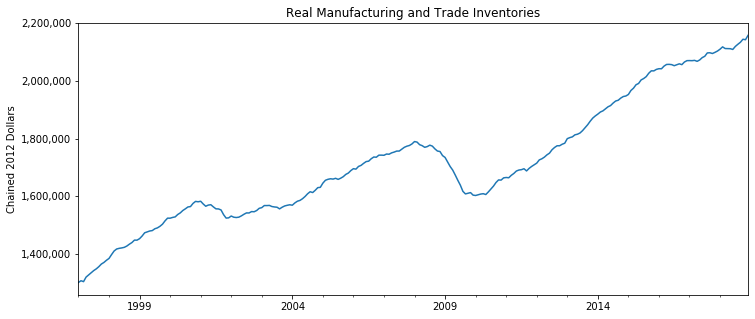

In [4]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Run an ETS Decomposition 

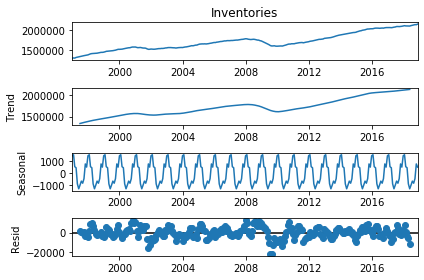

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

# determine ARIMA Orders¶

In [6]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Tue, 12 May 2020   AIC                           5348.037
Time:                        11:33:34   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Run the augmented Dickey-Fuller Test on the First Difference¶

In [9]:
from statsmodels.tsa.statespace.tools import diff
df2['diff_1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['diff_1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# Run the ACF and PACF plots¶

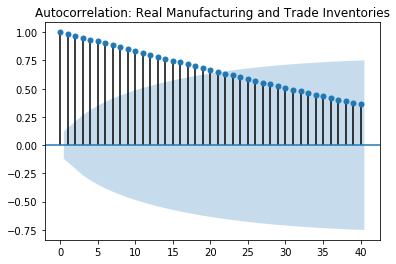

In [11]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

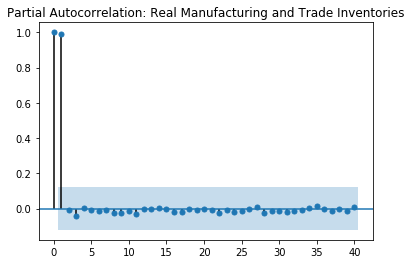

In [12]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

In [13]:
#AR=1(ACCORING TO LAG=1)(in pacf)
#MA=0 OR 1(in acf plot)
#I=1

In [14]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5348.037, BIC=5355.181, Time=0.018 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=5399.843, BIC=5410.560, Time=0.052 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5350.241, BIC=5360.957, Time=0.038 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=5409.217, BIC=5412.789, Time=0.009 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5378.835, BIC=5393.124, Time=0.139 seconds
Total fit time: 0.265 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Tue, 12 May 2020   AIC                           5348.037
Time:                        11:57:03   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
#ariam(1,1,1)best model

In [16]:
len(df2)

264

In [17]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

# Fit an ARIMA(1,1,1) Model

In [18]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.394
Method:                       css-mle   S.D. of innovations           4845.008
Date:                Tue, 12 May 2020   AIC                           4980.788
Time:                        12:00:36   BIC                           4994.890
Sample:                    02-01-1997   HQIC                          4986.463
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3233.7679   1344.917      2.404      0.016     597.779    5869.757
ar.L1.D.Inventories     0.9026      0.039     23.012      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [20]:
predictions


2018-01-01    2.107156e+06
2018-02-01    2.110545e+06
2018-03-01    2.113918e+06
2018-04-01    2.117278e+06
2018-05-01    2.120626e+06
2018-06-01    2.123962e+06
2018-07-01    2.127289e+06
2018-08-01    2.130606e+06
2018-09-01    2.133916e+06
2018-10-01    2.137218e+06
2018-11-01    2.140513e+06
2018-12-01    2.143802e+06
Freq: MS, Name: ARIMA(1,1,1) Predictions, dtype: float64

In [21]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2107156.294, expected=2110158
predicted=2110544.876, expected=2118199
predicted=2113918.373, expected=2112427
predicted=2117278.255, expected=2112276
predicted=2120625.849, expected=2111835
predicted=2123962.353, expected=2109298
predicted=2127288.846, expected=2119618
predicted=2130606.305, expected=2127170
predicted=2133915.609, expected=2134172
predicted=2137217.553, expected=2144639
predicted=2140512.854, expected=2143001
predicted=2143802.16 , expected=2158115


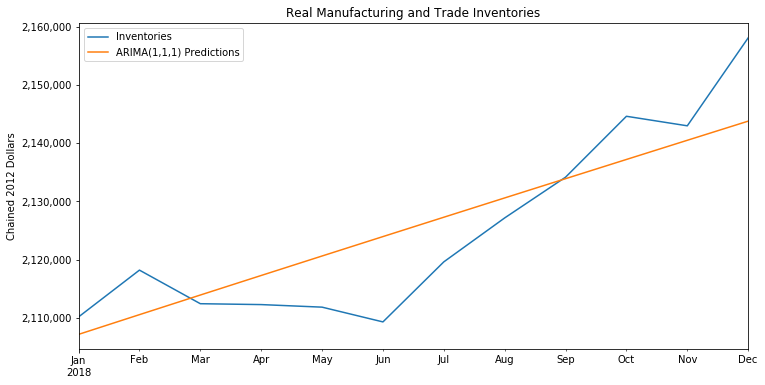

In [22]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Evaluate the Model

In [23]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 60333901.57


In [24]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 7767.490043


In [25]:
test['Inventories'].mean()

2125075.6666666665

In [27]:
predictions.mean()

2125569.1105313525

# Retrain the model on the full data, and forecast the future

In [28]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

In [29]:
fcast

2019-01-01    2.165602e+06
2019-02-01    2.172699e+06
2019-03-01    2.179443e+06
2019-04-01    2.185870e+06
2019-05-01    2.192009e+06
2019-06-01    2.197888e+06
2019-07-01    2.203532e+06
2019-08-01    2.208963e+06
2019-09-01    2.214203e+06
2019-10-01    2.219270e+06
2019-11-01    2.224180e+06
2019-12-01    2.228949e+06
Freq: MS, Name: ARIMA(1,1,1) Forecast, dtype: float64

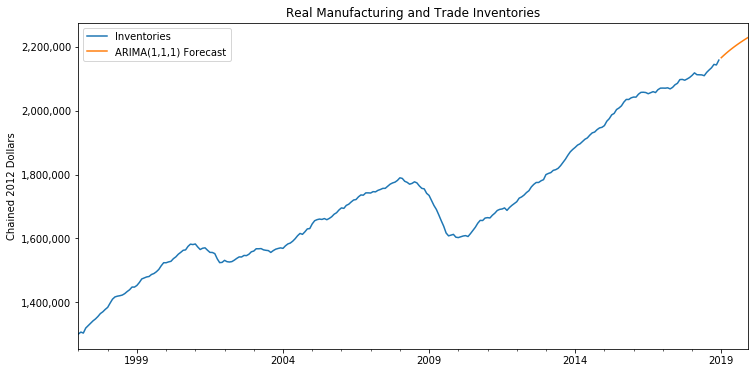

In [30]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# conclusion:it is a non-seasonal arima or stationary arima model procedure
    for a single column